In [1]:
import os
from skimage import io
import pandas as pd
import face_recognition
import matplotlib.pyplot as plt
import torch
import numpy as np
import albumentations
from facenet_pytorch import MTCNN, InceptionResnetV1
from tqdm.notebook import tqdm
import seaborn as sns

## Load Data

In [2]:
if os.environ.get('AM_I_ART_DATA') is not None:
    DATA_PATH = os.environ.get('AM_I_ART_DATA')
else:
    print( "Please set the environment variable AM_I_ART_DATA. Read the README!")

In [3]:
artists_path = os.path.join(DATA_PATH, "artists.csv")
artists_pd = pd.read_csv(artists_path)
artists_pd.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


## Generate test/art embedding

In [4]:
# Determine if an nvidia GPU is available
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [6]:
face_paths = []
face_positions = []
face_embeddings = []

for subdir, dirs, files in tqdm(list(os.walk(os.path.join(DATA_PATH, "images")))):
    for file in files:
        file_path = os.path.join(subdir, file)
        img = face_recognition.load_image_file(file_path)

        face_locations = face_recognition.face_locations(img)
        #print("{} rostros detectados!".format(len(face_locations)))
        if len(face_locations):
            for face_location in face_locations:

                # Print the location of each face in this image
                top, right, bottom, left = face_location

                # We take the face and transform it and cast into a torch format
                face = img[top:bottom, left:right]
                
                reshaped_face = albumentations.Resize(128,128)(image=face)["image"]
                img_batch = torch.from_numpy(reshaped_face.transpose(2,0,1))
                img_batch = img_batch.unsqueeze(0).type('torch.FloatTensor')
                img_embedding = resnet(img_batch).detach().cpu().numpy().squeeze()
                
                face_paths.append(file_path[file_path.find("images/"):])
                face_positions.append({"top":top, "right":right, "bottom":bottom, "left":left})
                face_embeddings.append(img_embedding)

In [11]:
np.save("art_embeddings.npy", np.array(face_embeddings))

In [31]:
df = pd.DataFrame({"face_path":face_paths, "face_positions":face_positions}, columns=['face_path', "face_positions"])
df['artist'] = [face_path.split("/")[-2] for face_path in df['face_path']]
df.head()

,face_path,face_positions,artist
0,images/Frida_Kahlo/Frida_Kahlo_1.jpg,"{'top': 350, 'right': 260, 'bottom': 617, 'lef...",Frida_Kahlo
1,images/Frida_Kahlo/Frida_Kahlo_10.jpg,"{'top': 101, 'right': 294, 'bottom': 163, 'lef...",Frida_Kahlo
2,images/Frida_Kahlo/Frida_Kahlo_101.jpg,"{'top': 170, 'right': 526, 'bottom': 491, 'lef...",Frida_Kahlo
3,images/Frida_Kahlo/Frida_Kahlo_102.jpg,"{'top': 139, 'right': 428, 'bottom': 325, 'lef...",Frida_Kahlo
4,images/Frida_Kahlo/Frida_Kahlo_103.jpg,"{'top': 356, 'right': 356, 'bottom': 511, 'lef...",Frida_Kahlo


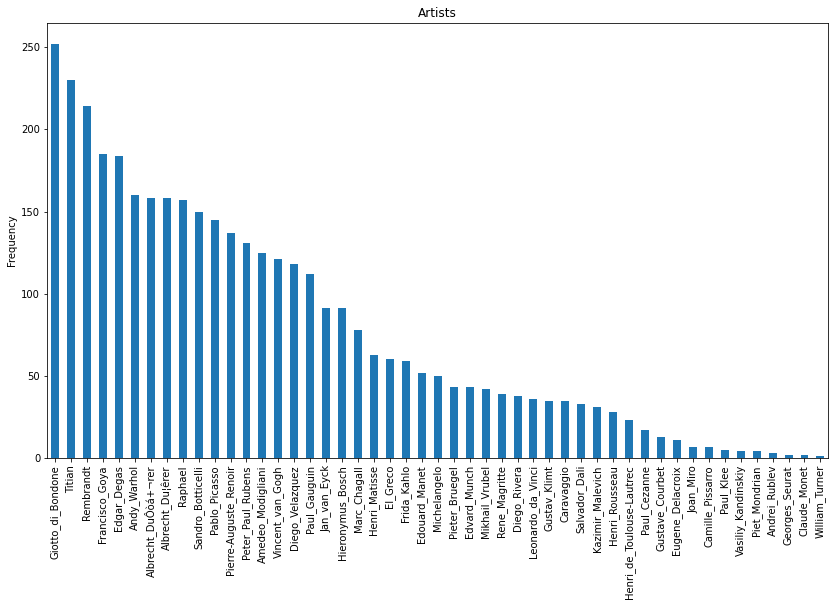

In [36]:
ax = df['artist'].value_counts().plot(kind='bar',figsize=(14,8), title="Artists")
ax.set_ylabel("Frequency")
plt.savefig("artist_frequency.jpg", bbox_inches='tight')
plt.show()

In [39]:
df.to_csv("embeddings_info.csv", index=False)

## Find nearest embedding

In [115]:
art_embeddings = np.load("art_embeddings.npy")
df = pd.read_csv("embeddings_info.csv")

In [69]:
def get_embedding(face):
    reshaped_face = albumentations.Resize(128,128)(image=face)["image"]
    img_batch = torch.from_numpy(reshaped_face.transpose(2,0,1))
    img_batch = img_batch.unsqueeze(0).type('torch.FloatTensor')
    img_embedding = resnet(img_batch).detach().cpu().numpy().squeeze()
    return img_embedding

In [70]:
def get_faces(img):
    res = []
    face_locations = face_recognition.face_locations(img)
    
    if len(face_locations):
        for face_location in face_locations:

            # Print the location of each face in this image
            top, right, bottom, left = face_location

            # We take the face and transform it and cast into a torch format
            face = img[top:bottom, left:right]
            
            res.append( { "face": face, "location": { "top":top, "right":right, "bottom":bottom, "left":left } } )
            
    return res

#### Example 1

(-0.5, 990.5, 557.5, -0.5)

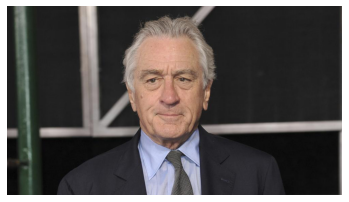

In [129]:
test_sample = face_recognition.load_image_file("samples/rdniro.jpg")
plt.imshow(test_sample); plt.axis("off")

In [130]:
img_faces = get_faces(test_sample)
if len(img_faces):
    for indx in range(len(img_faces)):
        face_embedding = get_embedding(img_faces[indx]["face"])

In [131]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [132]:
nearest_item = df.iloc[nearest_indx]
top = eval(nearest_item["face_positions"])["top"]
left = eval(nearest_item["face_positions"])["left"]
right = eval(nearest_item["face_positions"])["right"]
bottom = eval(nearest_item["face_positions"])["bottom"]

nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))
nearest_face = nearest_img[top:bottom, left:right]

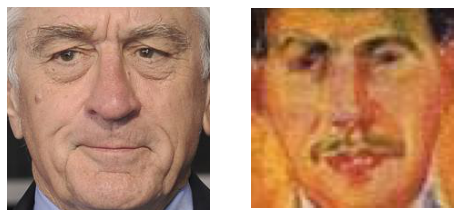

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.axis("off");ax2.axis("off")
ax1.imshow(img_faces[indx]["face"])
ax2.imshow(nearest_face)

#### Example 2

(-0.5, 745.5, 443.5, -0.5)

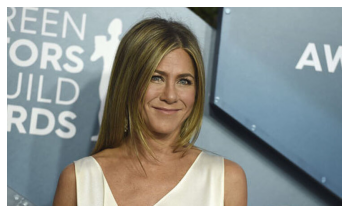

In [116]:
test_sample = face_recognition.load_image_file("samples/aniston.jpg")
plt.imshow(test_sample); plt.axis("off")

In [117]:
img_faces = get_faces(test_sample)
if len(img_faces):
    for indx in range(len(img_faces)):
        face_embedding = get_embedding(img_faces[indx]["face"])

In [118]:
dists = [np.linalg.norm(face_embedding - art_embedding) for art_embedding in art_embeddings]
nearest_indx = np.argmin(dists)

In [123]:
nearest_item = df.iloc[nearest_indx]
top = eval(nearest_item["face_positions"])["top"]
left = eval(nearest_item["face_positions"])["left"]
right = eval(nearest_item["face_positions"])["right"]
bottom = eval(nearest_item["face_positions"])["bottom"]

nearest_img = face_recognition.load_image_file( os.path.join(DATA_PATH, nearest_item["face_path"] ))
nearest_face = nearest_img[top:bottom, left:right]

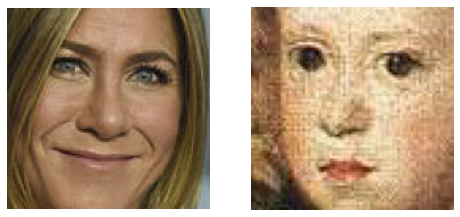

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.axis("off");ax2.axis("off")
ax1.imshow(img_faces[indx]["face"])
ax2.imshow(nearest_face)

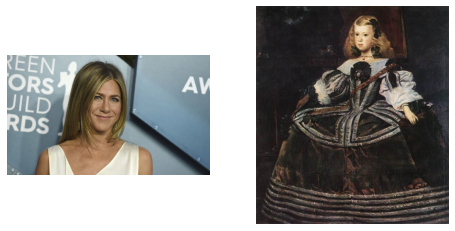

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.axis("off");ax2.axis("off")
ax1.imshow(test_sample)
ax2.imshow(nearest_img)